## Chapter 7: Regression with AWS Sagemaker

In [19]:
!pip install mysql-connector pymysql auto-sklearn

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [9]:
import pandas as pd
import numpy as np

import mysql.connector
import sys
import boto3
import os
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [10]:
ENDPOINT="toxicitydataset.cbowkysg1oyc.us-east-2.rds.amazonaws.com"
PORT="3306"
USR="admin"
DBNAME="toxicity_db_tutorial"
PASSWORD = "Slv6exdhmcR4uRDSzHvj"

In [11]:
from sqlalchemy import create_engine
import pandas as pd

db_connection_str = 'mysql+pymysql://{USR}:{PASSWORD}@{ENDPOINT}:{PORT}/{DBNAME}'.format(USR=USR, PASSWORD=PASSWORD, ENDPOINT=ENDPOINT, PORT=PORT, DBNAME=DBNAME)
db_connection = create_engine(db_connection_str)
df = pd.read_sql('SELECT * FROM dataset_toxicity_sd', con=db_connection)
df.head()

,ID,smiles,toxic,FormalCharge,TPSA,MolWt,HeavyAtoms,NHOH,HAcceptors,HDonors,Heteroatoms,AromaticRings,SaturatedRings,AromaticOH,AromaticN,LogP
0,25239916,c1c2c(c(c(c1[131I])[O-])[131I])Oc3c(cc(c(c3[13...,0,-2,81.65,987.667498,33,0,5,0,13,3,0,0,0,7.4338
1,25239917,CCC[C@@H]1C[C@H]([NH+](C1)C)C(=O)N[C@@H]([C@@H...,0,1,123.69,407.553000,27,6,7,6,9,0,2,4,0,-2.2741
2,25239918,CNC(=O)c1cc(ccn1)Oc2ccc(cc2)NC(=O)Nc3ccc(c(c3)...,0,0,92.35,464.831000,32,3,4,3,11,3,0,0,1,5.5497
3,25239919,CN(C)c1cccc2c1ccc(c2)S(=O)(=O)[O-],0,-1,60.44,250.299000,17,0,4,0,5,2,0,0,0,1.8099
4,25239920,CC(C)c1ccc2c(c1)c(=O)c3cc(c(nc3o2)N)C(=O)[O-],0,-1,109.25,297.290000,22,2,6,1,6,3,0,0,1,1.4103


In [12]:
X = df[["Heteroatoms", "MolWt", "HeavyAtoms", "NHOH", "HAcceptors", "HDonors"]]
y = df.TPSA.values.ravel()

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25)

In [24]:
import autosklearn.regression

automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    tmp_folder='/tmp/autosklearn_regression_example_tmp2',
)
automl.fit(X_train, y_train, dataset_name='dataset_toxicity')

AutoSklearnRegressor(per_run_time_limit=30, time_left_for_this_task=120,
                     tmp_folder='/tmp/autosklearn_regression_example_tmp2')

In [26]:
automl.get_models_with_weights()[0]

(0.44,
 SimpleRegressionPipeline({'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'minmax', 'feature_preprocessor:__choice__': 'polynomial', 'regressor:__choice__': 'extra_trees', 'feature_preprocessor:polynomial:degree': 2, 'feature_preprocessor:polynomial:include_bias': 'False', 'feature_preprocessor:polynomial:interaction_only': 'True', 'regressor:extra_trees:bootstrap': 'False', 'regressor:extra_trees:criterion': 'mse', 'regressor:extra_trees:max_depth': 'None', 'regressor:extra_trees:max_features': 0.9797793053686011, 'regressor:extra_trees:max_leaf_nodes': 'None', 'regressor:extra_trees:min_impurity_decrease': 0.0, 'regressor:extra_trees:min_samples_leaf': 1, 'regressor:extra_trees:min_samples_spli

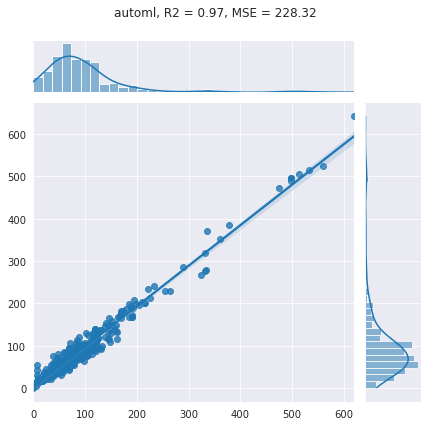

In [37]:
from sklearn.metrics import r2_score, mean_squared_error

predictions = automl.predict(X_test)
p = sns.jointplot(x=y_test, y=predictions, kind="reg")
p.fig.suptitle(f"automl, R2 = {round(r2_score(y_test, predictions), 3)}, MSE = {round(mean_squared_error(y_test, predictions), 2)}")
# p.ax_joint.collections[0].set_alpha(0)
# p.fig.tight_layout()
p.fig.subplots_adjust(top=0.90)